In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/healthcare-dataset/healthcare_dataset.csv


**Data Loading and Preprocessing**

In [2]:
import pandas as pd
# Load the dataset
df = pd.read_csv('/kaggle/input/healthcare-dataset/healthcare_dataset.csv')
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 Name                  0
Age                   0
Gender                0
Blood Type            0
Medical Condition     0
Date of Admission     0
Doctor                0
Hospital              0
Insurance Provider    0
Billing Amount        0
Room Number           0
Admission Type        0
Discharge Date        0
Medication            0
Test Results          0
dtype: int64


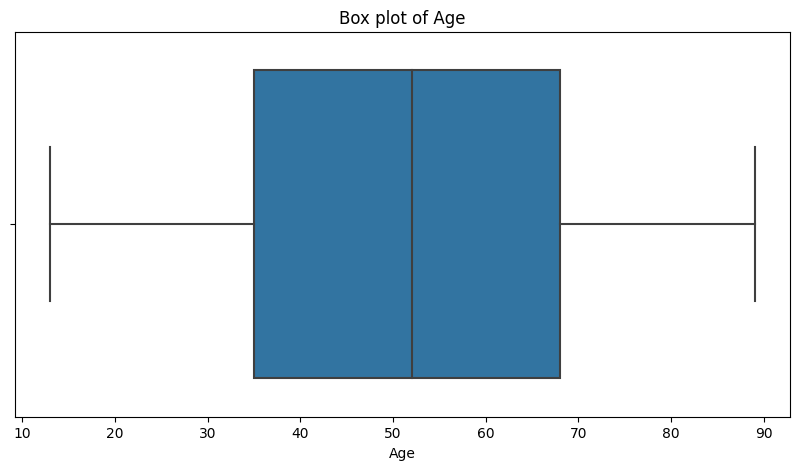

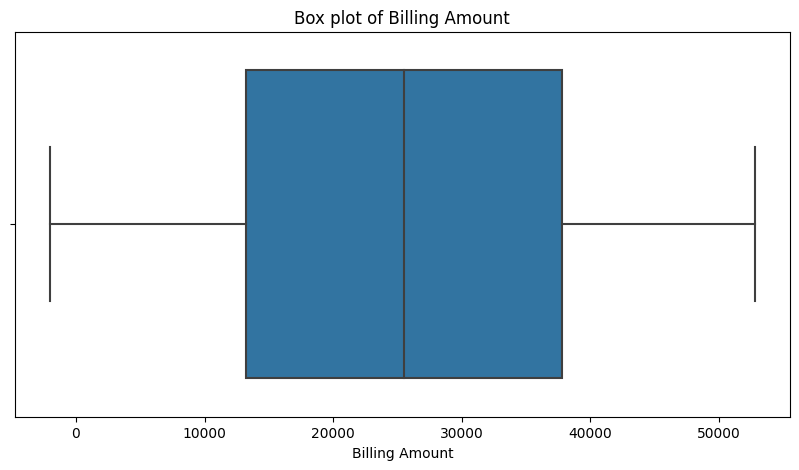

Data after handling outliers:
                 Age  Billing Amount   Room Number
count  55500.000000    55500.000000  55500.000000
mean      51.539459    25539.316097    301.134829
std       19.602454    14211.454431    115.243069
min       13.000000    -2008.492140    101.000000
25%       35.000000    13241.224652    202.000000
50%       52.000000    25538.069376    302.000000
75%       68.000000    37820.508436    401.000000
max       89.000000    52764.276736    500.000000


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
# Detect outliers using box plots
numerical_columns = ['Age', 'Billing Amount']
for col in numerical_columns:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df[col])
    plt.title(f'Box plot of {col}')
    plt.show()
# Handle outliers using the IQR method
Q1 = df[numerical_columns].quantile(0.25)
Q3 = df[numerical_columns].quantile(0.75)
IQR = Q3 - Q1
data_cleaned = df[~((df[numerical_columns] < (Q1 - 1.5 * IQR)) | (df[numerical_columns] > (Q3 + 1.5 * IQR))).any(axis=1)]
print("Data after handling outliers:\n", data_cleaned.describe())

In [4]:
# Remove negative values in the Billing Amount column
data_cleaned = data_cleaned[data_cleaned['Billing Amount'] >= 0]
# Check the result
print("Data after removing negative billing amounts:\n", data_cleaned['Billing Amount'].describe())

Data after removing negative billing amounts:
 count    55392.000000
mean     25590.084632
std      14178.657522
min          9.238787
25%      13297.478682
50%      25573.823359
75%      37849.210062
max      52764.276736
Name: Billing Amount, dtype: float64


In [5]:
data = data_cleaned

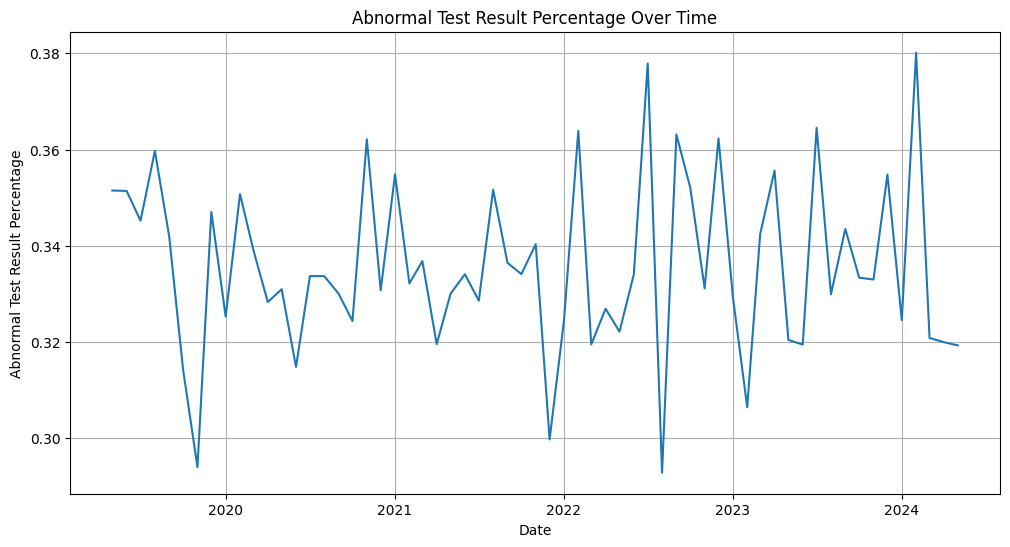

In [6]:
import pandas as pd
import numpy as np
# Assuming data_cleaned is your cleaned dataset
# Convert date columns to datetime format
data['Date of Admission'] = pd.to_datetime(data['Date of Admission'])
data['Discharge Date'] = pd.to_datetime(data['Discharge Date'])
# Extract month and year from admission date
data['Admission_Month'] = data['Date of Admission'].dt.month
data['Admission_Year'] = data['Date of Admission'].dt.year
# Define age groups
bins = [0, 18, 35, 50, 65, 100]
labels = ['0-18', '19-35', '36-50', '51-65', '66+']
data['Age Group'] = pd.cut(data['Age'], bins=bins, labels=labels)
# Aggregate data
grouped_data = data.groupby(['Admission_Year', 'Admission_Month'])['Test Results'].apply(lambda x: (x == 'Abnormal').mean()).reset_index()
grouped_data.rename(columns={'Test Results': 'Abnormal_Percentage'}, inplace=True)
# Create a date column for time series analysis
grouped_data['Date'] = pd.to_datetime(grouped_data['Admission_Year'].astype(str) + '-' + grouped_data['Admission_Month'].astype(str))
# Drop unnecessary columns
grouped_data.drop(columns=['Admission_Year', 'Admission_Month'], inplace=True)
# Set the date as the index
grouped_data.set_index('Date', inplace=True)
# Visualize the time series
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(grouped_data.index, grouped_data['Abnormal_Percentage'])
plt.title('Abnormal Test Result Percentage Over Time')
plt.xlabel('Date')
plt.ylabel('Abnormal Test Result Percentage')
plt.grid(True)
plt.show()

In [7]:
data = data.drop_duplicates()

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54860 entries, 0 to 55499
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Name                54860 non-null  object        
 1   Age                 54860 non-null  int64         
 2   Gender              54860 non-null  object        
 3   Blood Type          54860 non-null  object        
 4   Medical Condition   54860 non-null  object        
 5   Date of Admission   54860 non-null  datetime64[ns]
 6   Doctor              54860 non-null  object        
 7   Hospital            54860 non-null  object        
 8   Insurance Provider  54860 non-null  object        
 9   Billing Amount      54860 non-null  float64       
 10  Room Number         54860 non-null  int64         
 11  Admission Type      54860 non-null  object        
 12  Discharge Date      54860 non-null  datetime64[ns]
 13  Medication          54860 non-null  object        


**Data Visualization and Stastical Analysis**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


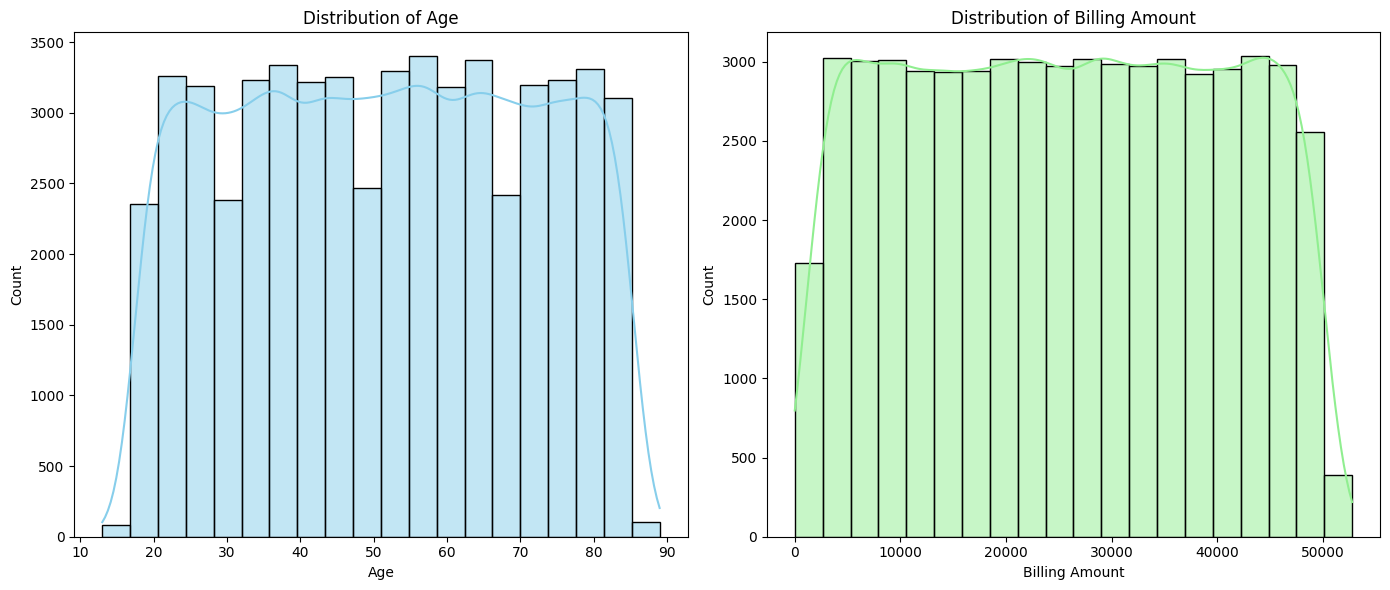

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
# Set up figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
# Plot Age distribution
sns.histplot(data_cleaned['Age'], bins=20, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of Age')
axes[0].set_xlabel('Age')
# Plot Billing Amount distribution
sns.histplot(data_cleaned['Billing Amount'], bins=20, kde=True, ax=axes[1], color='lightgreen')
axes[1].set_title('Distribution of Billing Amount')
axes[1].set_xlabel('Billing Amount')
plt.tight_layout()
plt.show()

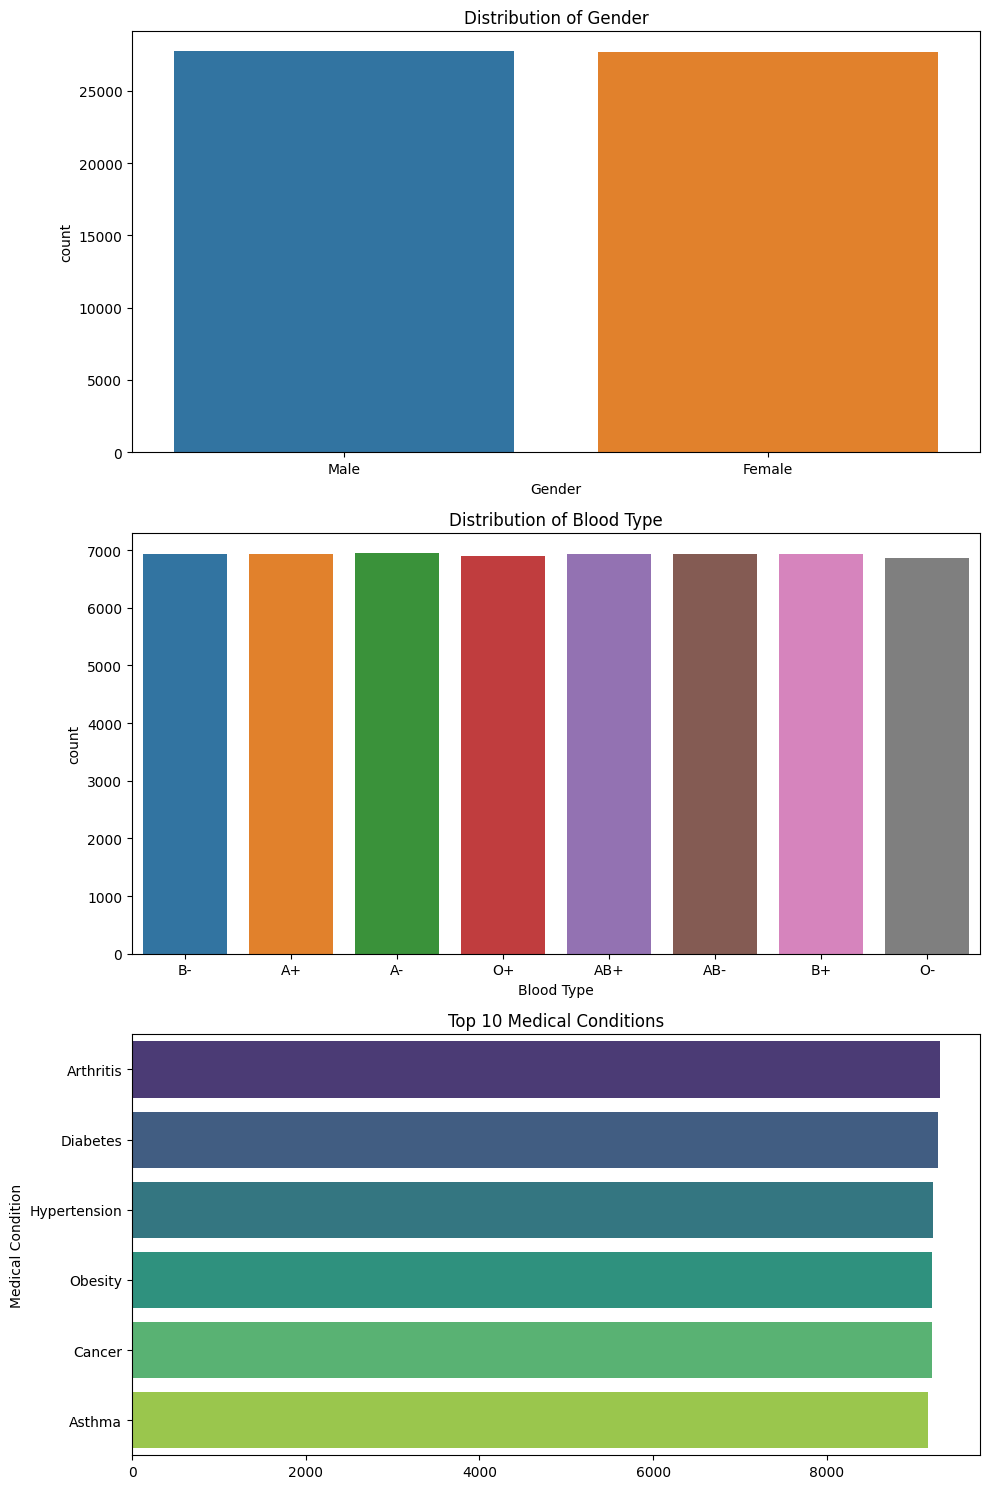

In [10]:
# Set up figure with subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))
# Plot Gender distribution
sns.countplot(x='Gender', data=data_cleaned, ax=axes[0])
axes[0].set_title('Distribution of Gender')
# Plot Blood Type distribution
sns.countplot(x='Blood Type', data=data_cleaned, ax=axes[1])
axes[1].set_title('Distribution of Blood Type')
# Plot Medical Condition distribution (top 10 most frequent conditions)
top_medical_conditions = data_cleaned['Medical Condition'].value_counts().nlargest(10)
sns.barplot(x=top_medical_conditions.values, y=top_medical_conditions.index, ax=axes[2], palette='viridis')
axes[2].set_title('Top 10 Medical Conditions')
plt.tight_layout()
plt.show()

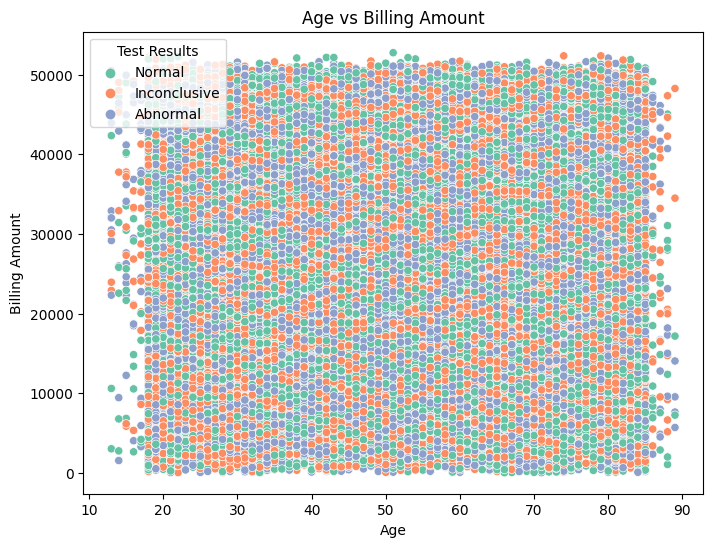

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


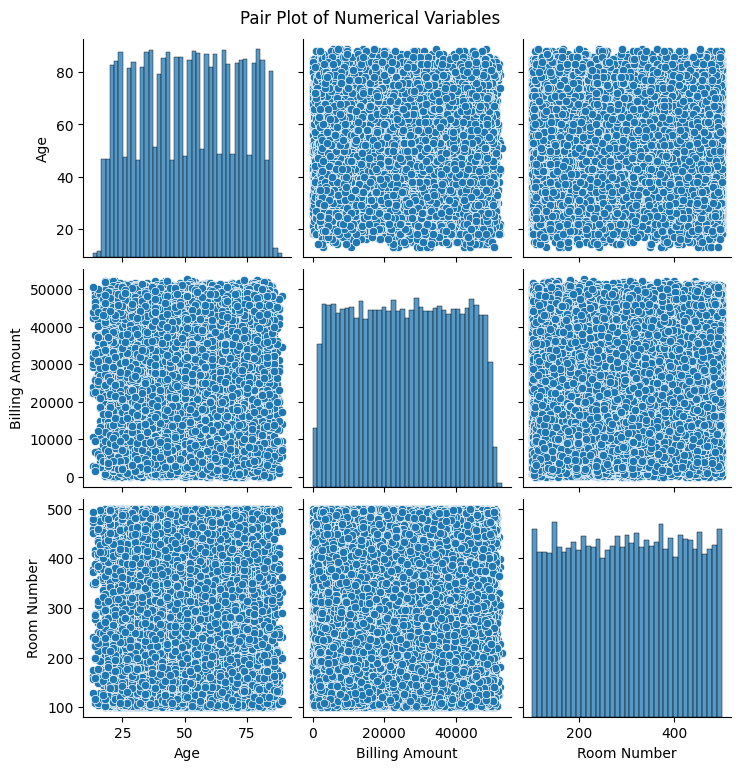

In [11]:
# Scatter plot of Age vs Billing Amount
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Age', y='Billing Amount', data=data_cleaned, hue='Test Results', palette='Set2')
plt.title('Age vs Billing Amount')
plt.xlabel('Age')
plt.ylabel('Billing Amount')
plt.show()
# Pair plot for selected numerical variables
sns.pairplot(data_cleaned[['Age', 'Billing Amount', 'Room Number']], diag_kind='hist')
plt.suptitle('Pair Plot of Numerical Variables', y=1.02)
plt.show()

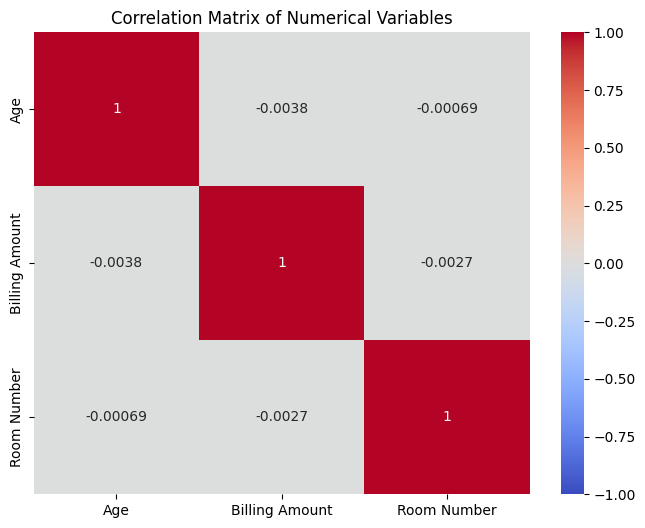

In [12]:
# Correlation matrix
correlation_matrix = data_cleaned[['Age', 'Billing Amount', 'Room Number']].corr()
# Visualize correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

In [13]:
from scipy.stats import chi2_contingency
# Example: Chi-square test for Gender vs Test Results
gender_test_results_ct = pd.crosstab(data_cleaned['Gender'], data_cleaned['Test Results'])
chi2, p, dof, expected = chi2_contingency(gender_test_results_ct)
print("Chi-square test results for Gender vs Test Results:")
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:\n", expected)

Chi-square test results for Gender vs Test Results:
Chi-square statistic: 2.110690393066583
P-value: 0.34807225323040364
Degrees of freedom: 2
Expected frequencies:
 [[9284.43230069 9147.58069757 9233.98700173]
 [9304.56769931 9167.41930243 9254.01299827]]


In [14]:
from scipy.stats import ttest_ind, f_oneway
# Example: Two-sample t-test for Age and Billing Amount between Normal and Abnormal Test Results
normal_age = data_cleaned[data_cleaned['Test Results'] == 'Normal']['Age']
abnormal_age = data_cleaned[data_cleaned['Test Results'] == 'Abnormal']['Age']
t_stat, p_value = ttest_ind(normal_age, abnormal_age)
print("Two-sample t-test results for Age between Normal and Abnormal Test Results:")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")
# Example: One-way ANOVA for Billing Amount across different Admission Types
anova_results = data_cleaned.groupby('Admission Type')['Billing Amount'].apply(list)
f_stat, p_value = f_oneway(*anova_results)
print("\nOne-way ANOVA results for Billing Amount across Admission Types:")
print(f"F-statistic: {f_stat}")
print(f"P-value: {p_value}")

Two-sample t-test results for Age between Normal and Abnormal Test Results:
T-statistic: -1.438923586672441
P-value: 0.15018061582748743

One-way ANOVA results for Billing Amount across Admission Types:
F-statistic: 0.30379085101576103
P-value: 0.738016435126035


**Model Training, Valuation, Cross validation, Hyperparamater Tuning**

In [15]:
# Generate lag features
def create_lag_features(df, lag=12):
    for i in range(1, lag + 1):
        df[f'lag_{i}'] = df['Abnormal_Percentage'].shift(i)
    return df
# Create lag features
grouped_data = create_lag_features(grouped_data)
# Drop rows with NaN values created by lag features
grouped_data.dropna(inplace=True)

from sklearn.preprocessing import StandardScaler
# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(grouped_data.drop(columns=['Abnormal_Percentage']))
y = grouped_data['Abnormal_Percentage'].values
# Reshape data for LSTM model
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split the data into train and test sets
train_size = int(len(grouped_data) * 0.8)
train, test = grouped_data[:train_size], grouped_data[train_size:]
# Split data into features (X) and target (y)
X_train, y_train = train.drop(columns=['Abnormal_Percentage']), train['Abnormal_Percentage']
X_test, y_test = test.drop(columns=['Abnormal_Percentage']), test['Abnormal_Percentage']
# Reshape data for LSTM model
X_train = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

In [16]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
# Define LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

2024-07-18 12:31:28.214751: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-18 12:31:28.214888: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-18 12:31:28.482208: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - loss: 0.1050

I0000 00:00:1721305908.291253      77 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.1031 - val_loss: 0.0914
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0902 - val_loss: 0.0800
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0787 - val_loss: 0.0695
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0681 - val_loss: 0.0595
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0590 - val_loss: 0.0501
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0494 - val_loss: 0.0412
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0408 - val_loss: 0.0332
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0328 - val_loss: 0.0260
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0257 - val_loss: 0.0194
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0190 - val_loss: 0.0134
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0132 - val_loss: 0.0084
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0083 - val_loss: 0.0045
Epo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


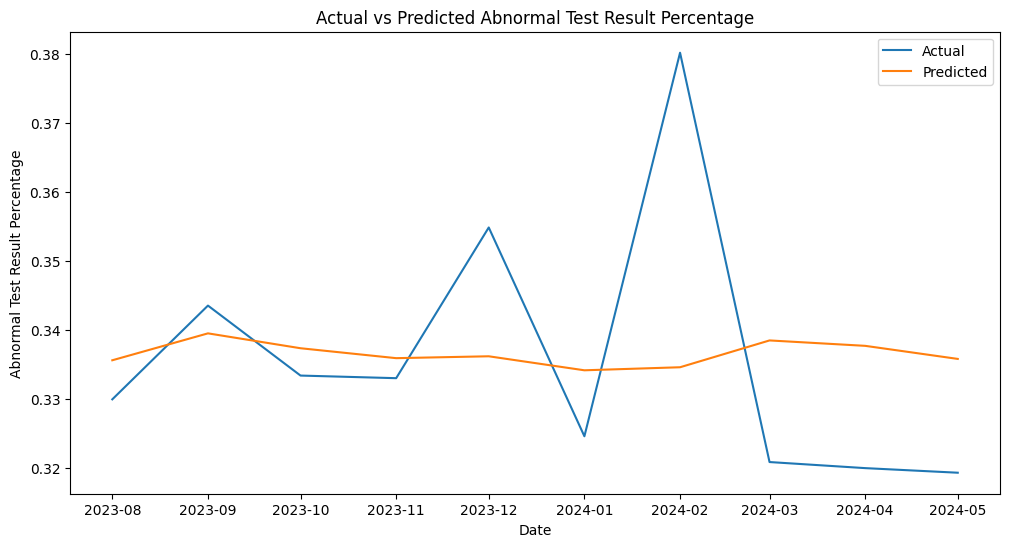

Mean Squared Error: 0.0003489141148430608
Mean Absolute Error: 0.014224924281954526
R-squared: -0.053095854339175075


In [17]:
# Make predictions
y_pred = model.predict(X_test)
# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Actual')
plt.plot(test.index, y_pred, label='Predicted')
plt.title('Actual vs Predicted Abnormal Test Result Percentage')
plt.xlabel('Date')
plt.ylabel('Abnormal Test Result Percentage')
plt.legend()
plt.show()
# Evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
# Create TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=3)
# Initialize lists to store the results
mse_scores = []
mae_scores = []
r2_scores = []
# Prepare the data
X = grouped_data.drop(columns=['Abnormal_Percentage'])
y = grouped_data['Abnormal_Percentage']
# Reshape data for LSTM model
X = X.values.reshape(X.shape[0], X.shape[1], 1)
# Time series cross-validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=True))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    # Fit the model with early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)
# Calculate average metrics
mean_mse = np.mean(mse_scores)
mean_mae = np.mean(mae_scores)
mean_r2 = np.mean(r2_scores)
print(f'Average Mean Squared Error: {mean_mse}')
print(f'Average Mean Absolute Error: {mean_mae}')
print(f'Average R-squared: {mean_r2}')

Epoch 1/200


/tmp/ipykernel_25/4218363400.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train, y_test = y[train_index], y[test_index]
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.0829 - val_loss: 0.0727
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0736 - val_loss: 0.0642
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0651 - val_loss: 0.0561
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0570 - val_loss: 0.0481
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0490 - val_loss: 0.0406
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0413 - val_loss: 0.0333
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0340 - val_loss: 0.0262
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0269 - val_loss: 0.0195
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0201 - val_loss: 0.0133
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0138 - val_loss: 0.0080
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0083 - val_loss: 0.0037
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0039 - val_loss: 0.0010
Epo

/tmp/ipykernel_25/4218363400.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train, y_test = y[train_index], y[test_index]
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.1025 - val_loss: 0.0978
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0935 - val_loss: 0.0893
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0852 - val_loss: 0.0814
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0775 - val_loss: 0.0735
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0698 - val_loss: 0.0657
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0622 - val_loss: 0.0580
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0547 - val_loss: 0.0504
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0473 - val_loss: 0.0428
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0399 - val_loss: 0.0353
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0327 - val_loss: 0.0280
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0257 - val_loss: 0.0211
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0190 - val_loss: 0.0146
Epo

/tmp/ipykernel_25/4218363400.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train, y_test = y[train_index], y[test_index]
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 0.1157 - val_loss: 0.1063
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1040 - val_loss: 0.0961
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0943 - val_loss: 0.0870
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0856 - val_loss: 0.0779
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0764 - val_loss: 0.0689
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0671 - val_loss: 0.0596
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0579 - val_loss: 0.0494
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0484 - val_loss: 0.0388
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0377 - val_loss: 0.0280
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0272 - val_loss: 0.0175
Epoch 11/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0164 - val_loss: 0.0082
Epoch 12/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0079 - val_loss: 0.0019
Epo

In [19]:
model.save('lstm_model.h5')